<a href="https://colab.research.google.com/github/samreensabasyeda/mlproject/blob/main/ner_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT** **LIBRARIES**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

**PRE**-**PROCESSING**

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**DEEP LEARNING**

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Dense, TimeDistributed,
                                      Dropout, Bidirectional, Input)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.19.0


**2. LOAD AND EXPLORE DATA**

In [6]:
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [7]:
# Fill NaN values in sentence

df['Sentence #'].fillna(method='ffill', inplace=True)

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(15))


Dataset loaded successfully!

Dataset shape: (1048575, 4)

First few rows:
     Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O


In [9]:
# Basic statistics

print(f"\n{'='*60}")
print("DATASET STATISTICS")
print(f"{'='*60}")
print(f"Total rows: {len(df)}")
print(f"Total unique sentences: {df['Sentence #'].nunique()}")
print(f"Total unique words: {df['Word'].nunique()}")
print(f"Total unique POS tags: {df['POS'].nunique()}")
print(f"Total unique NER tags: {df['Tag'].nunique()}")



DATASET STATISTICS
Total rows: 1048575
Total unique sentences: 47959
Total unique words: 35177
Total unique POS tags: 42
Total unique NER tags: 17


In [10]:
# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())


Missing values:
Sentence #     0
Word          10
POS            0
Tag            0
dtype: int64


In [11]:

# Distribution of NER tags
print(f"\n{'='*60}")
print("NER TAG DISTRIBUTION")
print(f"{'='*60}")
tag_counts = df['Tag'].value_counts()
print(tag_counts)


NER TAG DISTRIBUTION
Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


**3.DATA VISUALIZATION**

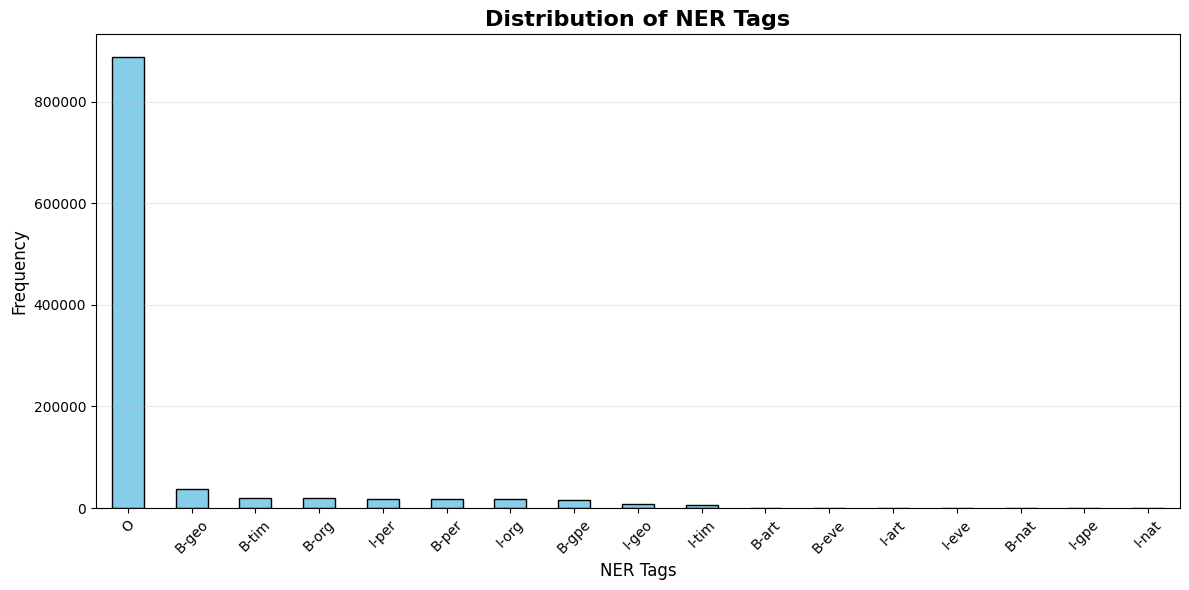

In [12]:
# Visualize tag distribution
plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of NER Tags', fontsize=16, fontweight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


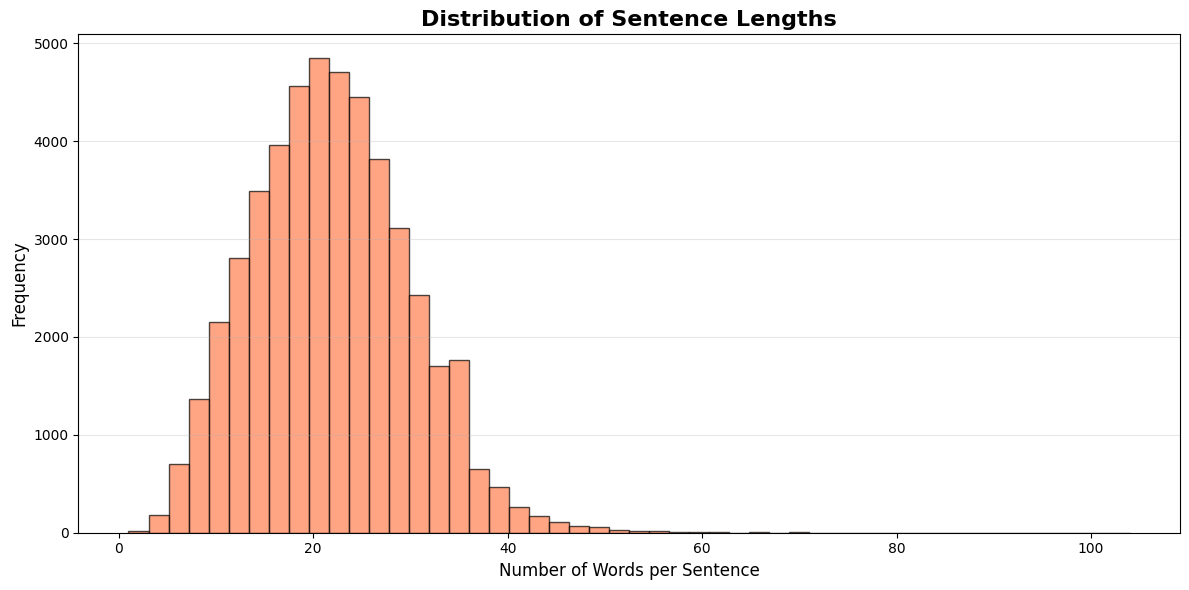


Sentence Length Statistics:
Mean: 21.86
Median: 21.00
Max: 104
Min: 1


In [14]:
# Sentence length distribution
sentence_lengths = df.groupby('Sentence #').size()
plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Sentence Lengths', fontsize=16, fontweight='bold')
plt.xlabel('Number of Words per Sentence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


print(f"\nSentence Length Statistics:")
print(f"Mean: {sentence_lengths.mean():.2f}")
print(f"Median: {sentence_lengths.median():.2f}")
print(f"Max: {sentence_lengths.max()}")
print(f"Min: {sentence_lengths.min()}")

**4.DATA PREPROCESSING**

In [16]:
print(f"\n{'='*60}")
print("DATA PREPROCESSING")
print(f"{'='*60}")


DATA PREPROCESSING


In [17]:
# Group by sentences
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                            s['POS'].values.tolist(),
                                                            s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(df)
sentences = getter.sentences

print(f"Total sentences: {len(sentences)}")
print(f"\nExample sentence:")
print(sentences[0])

Total sentences: 47959

Example sentence:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [18]:
# Extract words and tags
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]

print(f"\nExample processed:")
print(f"Words: {X[0]}")
print(f"Tags: {y[0]}")



Example processed:
Words: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [19]:
# Get unique words and tags
words = list(set(df['Word'].values))
words.append('ENDPAD')
words.append('UNK')  # For unknown words
n_words = len(words)

tags = list(set(df['Tag'].values))
n_tags = len(tags)

print(f"\nVocabulary size: {n_words}")
print(f"Number of tags: {n_tags}")
print(f"Tags: {tags}")


Vocabulary size: 35180
Number of tags: 17
Tags: ['I-tim', 'B-eve', 'I-art', 'B-per', 'I-per', 'B-tim', 'B-art', 'I-nat', 'B-nat', 'O', 'I-eve', 'I-geo', 'I-org', 'B-gpe', 'B-org', 'I-gpe', 'B-geo']


In [20]:
# Create word and tag dictionaries
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

print(f"\nTag to index mapping:")
for tag, idx in tag2idx.items():
    print(f"  {tag}: {idx}")


Tag to index mapping:
  I-tim: 0
  B-eve: 1
  I-art: 2
  B-per: 3
  I-per: 4
  B-tim: 5
  B-art: 6
  I-nat: 7
  B-nat: 8
  O: 9
  I-eve: 10
  I-geo: 11
  I-org: 12
  B-gpe: 13
  B-org: 14
  I-gpe: 15
  B-geo: 16


**5.SEQUENCE PREPARATION**

In [21]:
print(f"\n{'='*60}")
print("SEQUENCE PREPARATION")
print(f"{'='*60}")


SEQUENCE PREPARATION


In [23]:
# Convert words to indices
X_encoded = [[word2idx.get(w, word2idx['UNK']) for w in s] for s in X]

# Convert tags to indices
y_encoded = [[tag2idx[t] for t in s] for s in y]

In [24]:
# Pad sequences to same length
max_len = 50  # Maximum sequence length
print(f"Maximum sequence length set to: {max_len}")

X_padded = pad_sequences(maxlen=max_len, sequences=X_encoded,
                         padding='post', value=word2idx['ENDPAD'])
y_padded = pad_sequences(maxlen=max_len, sequences=y_encoded,
                         padding='post', value=tag2idx['O'])

print(f"\nShape after padding:")
print(f"X_padded: {X_padded.shape}")
print(f"y_padded: {y_padded.shape}")

Maximum sequence length set to: 50

Shape after padding:
X_padded: (47959, 50)
y_padded: (47959, 50)


In [25]:
# One-hot encode the tags
y_categorical = np.array([to_categorical(i, num_classes=n_tags) for i in y_padded])
print(f"y_categorical shape: {y_categorical.shape}")

y_categorical shape: (47959, 50, 17)


**6.TRAIN-VALIDATION-TEST SPLIT**

In [26]:
print(f"\n{'='*60}")
print("DATA SPLITTING")
print(f"{'='*60}")


DATA SPLITTING


Training set: 30693 sentences (64.0%)
Validation set: 7674 sentences (16.0%)
Test set: 9592 sentences (20.0%)

Training baseline model...
Epoch 1/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step - accuracy: 0.9314 - loss: 0.4250 - val_accuracy: 0.9688 - val_loss: 0.1194
Epoch 2/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 90s 86ms/step - accuracy: 0.9759 - loss: 0.0957 - val_accuracy: 0.9810 - val_loss: 0.0701
Epoch 3/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 76s 79ms/step - accuracy: 0.9846 - loss: 0.0552 - val_accuracy: 0.9827 - val_loss: 0.0593
Epoch 4/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 74s 77ms/step - accuracy: 0.9869 - loss: 0.0428 - val_accuracy: 0.9826 - val_loss: 0.0595
Epoch 5/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9884 - loss: 0.0361 - val_accuracy: 0.9815 - val_loss: 0.0606
Epoch 6/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.9894 - loss: 0.0324 - val_accuracy: 0.9826 - val_loss: 0.0593
Epoch 7/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 74s 77ms/step - accuracy: 0.9904 - loss: 0

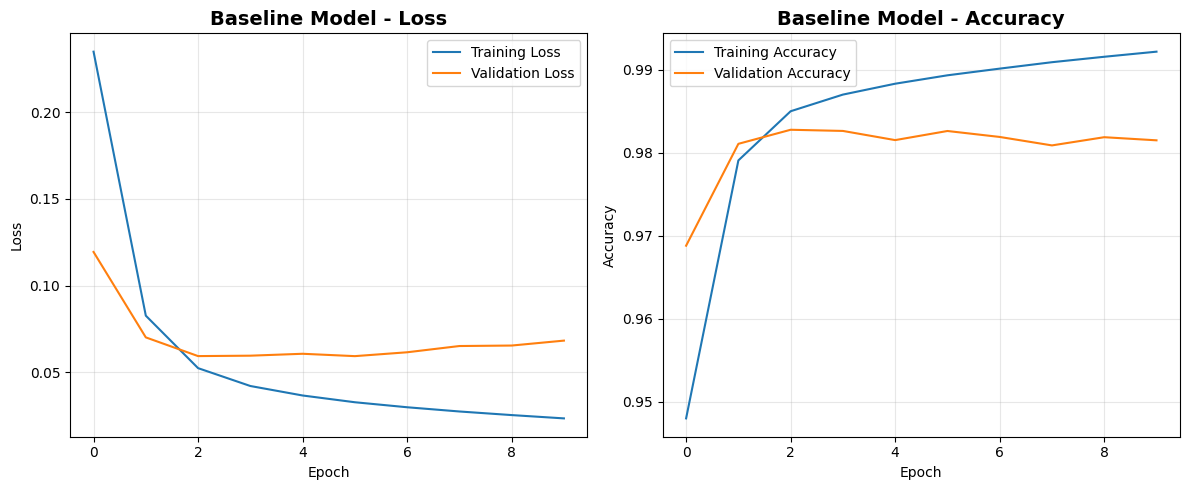

In [39]:
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_padded, y_categorical, test_size=0.2, random_state=42
)

# Second split: separate train and validation (80-20 of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} sentences ({X_train.shape[0]/len(X_padded)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} sentences ({X_val.shape[0]/len(X_padded)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} sentences ({X_test.shape[0]/len(X_padded)*100:.1f}%)")



# Train baseline model
print("\nTraining baseline model...")
history_baseline = baseline_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**7.BASELINE MODEL (SIMPLE LSTM)**

In [38]:
print(f"\n{'='*60}")
print("BUILDING BASELINE MODEL")
print(f"{'='*60}")

# Define baseline model
def create_baseline_model(n_words, n_tags, max_len):
    model = Sequential([
        Embedding(input_dim=n_words + 1, output_dim=50, input_length=max_len),
        LSTM(units=100, return_sequences=True),
        TimeDistributed(Dense(n_tags, activation='softmax'))
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

baseline_model = create_baseline_model(n_words, n_tags, max_len)
print("\nBaseline Model Architecture:")
baseline_model.summary()




BUILDING BASELINE MODEL

Baseline Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**8.EVALUATE BASELINE MODEL**

In [40]:
print(f"\n{'='*60}")
print("BASELINE MODEL EVALUATION")
print(f"{'='*60}")

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)
y_pred_baseline = np.argmax(y_pred_baseline, axis=-1)
y_test_labels = np.argmax(y_test, axis=-1)




BASELINE MODEL EVALUATION
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [43]:
# Flatten predictions and true labels (excluding padding)
def get_flat_labels(y_true, y_pred, tag2idx):
    true_labels = []
    pred_labels = []

    for i in range(len(y_true)):
        for j in range(len(y_true[i])):
            if y_true[i][j] != tag2idx['O'] or y_pred[i][j] != tag2idx['O']:
                true_labels.append(idx2tag[y_true[i][j]])
                pred_labels.append(idx2tag[y_pred[i][j]])

    return true_labels, pred_labels

true_labels_baseline, pred_labels_baseline = get_flat_labels(
    y_test_labels, y_pred_baseline, tag2idx
)

# Classification report
print("\nClassification Report (Baseline):")
print(classification_report(true_labels_baseline, pred_labels_baseline))

# F1 Score
from sklearn.metrics import f1_score
f1_baseline = f1_score(true_labels_baseline, pred_labels_baseline, average='weighted')
print(f"\nWeighted F1-Score (Baseline): {f1_baseline:.4f}")


Classification Report (Baseline):
              precision    recall  f1-score   support

       B-art       0.06      0.01      0.02        94
       B-eve       0.59      0.23      0.33        70
       B-geo       0.79      0.88      0.83      7556
       B-gpe       0.95      0.93      0.94      3137
       B-nat       0.56      0.25      0.34        40
       B-org       0.67      0.60      0.63      4148
       B-per       0.82      0.76      0.79      3397
       B-tim       0.88      0.81      0.84      4074
       I-art       0.04      0.02      0.03        84
       I-eve       0.00      0.00      0.00        65
       I-geo       0.74      0.77      0.75      1461
       I-gpe       0.94      0.52      0.67        33
       I-nat       0.00      0.00      0.00        13
       I-org       0.74      0.71      0.72      3391
       I-per       0.86      0.84      0.85      3404
       I-tim       0.77      0.70      0.73      1249
           O       0.00      0.00      0.00   

**9.ADVANCED MODEL (Bidirectional LSTM with Dropout)**


BUILDING ADVANCED MODEL

Advanced Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     3,518,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 200)        │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 17)         │         3,417 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,682,317 (14.05 MB)

 Trainable params: 3,682,317 (14.05 MB)

 Non-trainable params: 0 (0.00 B)


Training advanced model...
Epoch 1/15
960/960 ━━━━━━━━━━━━━━━━━━━━ 258s 257ms/step - accuracy: 0.9398 - loss: 0.3093 - val_accuracy: 0.9817 - val_loss: 0.0619
Epoch 2/15
960/960 ━━━━━━━━━━━━━━━━━━━━ 262s 258ms/step - accuracy: 0.9849 - loss: 0.0511 - val_accuracy: 0.9850 - val_loss: 0.0493
Epoch 3/15
960/960 ━━━━━━━━━━━━━━━━━━━━ 244s 255ms/step - accuracy: 0.9888 - loss: 0.0364 - val_accuracy: 0.9857 - val_loss: 0.0472
Epoch 4/15
960/960 ━━━━━━━━━━━━━━━━━━━━ 242s 253ms/step - accuracy: 0.9907 - loss: 0.0292 - val_accuracy: 0.9858 - val_loss: 0.0477
Epoch 5/15
960/960 ━━━━━━━━━━━━━━━━━━━━ 244s 254ms/step - accuracy: 0.9922 - loss: 0.0244 - val_accuracy: 0.9855 - val_loss: 0.0497
Epoch 6/15
960/960 ━━━━━━━━━━━━━━━━━━━━ 243s 254ms/step - accuracy: 0.9932 - loss: 0.0210 - val_accuracy: 0.9852 - val_loss: 0.0527


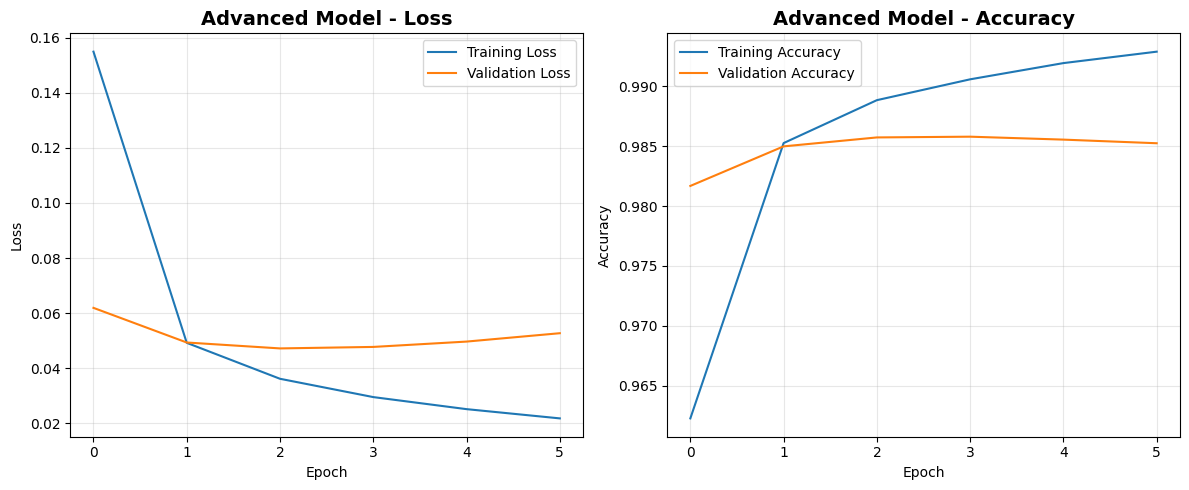

In [44]:

print(f"\n{'='*60}")
print("BUILDING ADVANCED MODEL")
print(f"{'='*60}")

def create_advanced_model(n_words, n_tags, max_len):
    input_layer = Input(shape=(max_len,))
    model = Embedding(input_dim=n_words + 1, output_dim=100, input_length=max_len)(input_layer)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    model = Dropout(0.1)(model)
    output_layer = TimeDistributed(Dense(n_tags, activation='softmax'))(model)

    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

advanced_model = create_advanced_model(n_words, n_tags, max_len)
print("\nAdvanced Model Architecture:")
advanced_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train advanced model
print("\nTraining advanced model...")
history_advanced = advanced_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_advanced.history['loss'], label='Training Loss')
plt.plot(history_advanced.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_advanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Model - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**10. EVALUATE ADVANCED MODEL**

In [45]:
print(f"\n{'='*60}")
print("ADVANCED MODEL EVALUATION")
print(f"{'='*60}")

# Predict on test set
y_pred_advanced = advanced_model.predict(X_test)
y_pred_advanced = np.argmax(y_pred_advanced, axis=-1)

# Flatten predictions and true labels
true_labels_advanced, pred_labels_advanced = get_flat_labels(
    y_test_labels, y_pred_advanced, tag2idx
)

# Classification report
print("\nClassification Report (Advanced):")
print(classification_report(true_labels_advanced, pred_labels_advanced))

# F1 Score
f1_advanced = f1_score(true_labels_advanced, pred_labels_advanced, average='weighted')
print(f"\nWeighted F1-Score (Advanced): {f1_advanced:.4f}")


ADVANCED MODEL EVALUATION
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step

Classification Report (Advanced):
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        94
       B-eve       0.78      0.20      0.32        70
       B-geo       0.85      0.91      0.87      7556
       B-gpe       0.96      0.93      0.95      3137
       B-nat       0.00      0.00      0.00        40
       B-org       0.80      0.68      0.74      4148
       B-per       0.85      0.81      0.83      3397
       B-tim       0.93      0.85      0.89      4074
       I-art       0.00      0.00      0.00        84
       I-eve       0.00      0.00      0.00        65
       I-geo       0.80      0.78      0.79      1461
       I-gpe       0.92      0.36      0.52        33
       I-nat       0.00      0.00      0.00        13
       I-org       0.81      0.75      0.78      3391
       I-per       0.84      0.89      0.87      3404
       I-tim       0.85      0

**11.MODEL COMPARISON**


MODEL COMPARISON

             Model  F1-Score  Improvement
  Baseline (LSTM)  0.743263     0.000000
Advanced (BiLSTM)  0.806931     8.565986


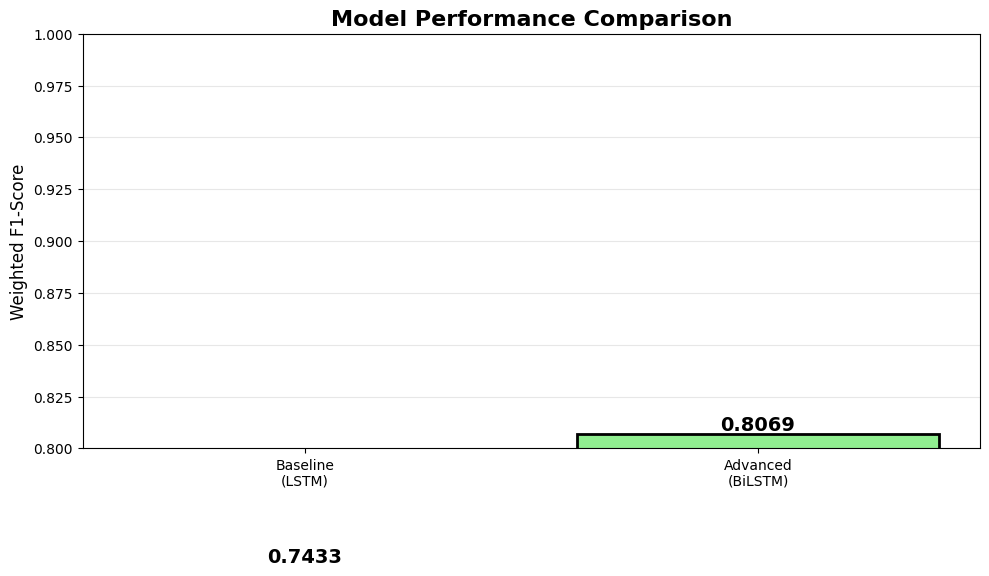

In [46]:

print(f"\n{'='*60}")
print("MODEL COMPARISON")
print(f"{'='*60}")

comparison_df = pd.DataFrame({
    'Model': ['Baseline (LSTM)', 'Advanced (BiLSTM)'],
    'F1-Score': [f1_baseline, f1_advanced],
    'Improvement': [0, ((f1_advanced - f1_baseline) / f1_baseline * 100)]
})

print("\n", comparison_df.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
models = ['Baseline\n(LSTM)', 'Advanced\n(BiLSTM)']
scores = [f1_baseline, f1_advanced]
colors = ['skyblue', 'lightgreen']

bars = plt.bar(models, scores, color=colors, edgecolor='black', linewidth=2)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Weighted F1-Score', fontsize=12)
plt.ylim(0.8, 1.0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


# ============================================================================
# STEP 12: PREDICTION FUNCTION
# ============================================================================

def predict_ner(sentence, model, word2idx, idx2tag, max_len):
    """
    Predict NER tags for a given sentence
    """
    # Tokenize sentence
    words = sentence.split()

    # Convert to indices
    x = [word2idx.get(w, word2idx['UNK']) for w in words]

    # Pad sequence
    x = pad_sequences(maxlen=max_len, sequences=[x], padding='post',
                      value=word2idx['ENDPAD'])

    # Predict
    pred = model.predict(x, verbose=0)
    pred = np.argmax(pred, axis=-1)[0]

    # Convert indices to tags
    predicted_tags = [idx2tag[i] for i in pred[:len(words)]]

    return list(zip(words, predicted_tags))


**11.TEST WITH EXAMPLES**

In [47]:
print(f"\n{'='*60}")
print("TESTING WITH EXAMPLE SENTENCES")
print(f"{'='*60}")

test_sentences = [
    "John lives in New York",
    "Apple Inc is located in California",
    "Barack Obama was the president of United States",
    "Google and Microsoft are tech companies"
]

for sentence in test_sentences:
    print(f"\nSentence: {sentence}")
    result = predict_ner(sentence, advanced_model, word2idx, idx2tag, max_len)
    print("Predictions:")
    for word, tag in result:
        if tag != 'O':
            print(f"  {word} -> {tag}")


TESTING WITH EXAMPLE SENTENCES

Sentence: John lives in New York
Predictions:
  John -> B-per
  New -> B-geo
  York -> I-geo

Sentence: Apple Inc is located in California
Predictions:
  Apple -> B-org
  Inc -> I-org
  California -> B-geo

Sentence: Barack Obama was the president of United States
Predictions:
  Barack -> B-per
  Obama -> I-per
  United -> B-geo
  States -> I-geo

Sentence: Google and Microsoft are tech companies
Predictions:
  Google -> B-org
  Microsoft -> B-org


**14.SAVE MODEL**

In [48]:
print(f"\n{'='*60}")
print("SAVING MODEL")
print(f"{'='*60}")

# Save the advanced model
advanced_model.save('ner_bilstm_model.h5')
print("Model saved as 'ner_bilstm_model.h5'")

# Save word and tag mappings
import pickle

with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

with open('tag2idx.pkl', 'wb') as f:
    pickle.dump(tag2idx, f)

with open('idx2tag.pkl', 'wb') as f:
    pickle.dump(idx2tag, f)

print("Mappings saved successfully!")



SAVING MODEL
Model saved as 'ner_bilstm_model.h5'
Mappings saved successfully!


**15.SUMMARY AND RECOMMENDATIONS**

In [49]:
print(f"\n{'='*60}")
print("PROJECT SUMMARY")
print(f"{'='*60}")

print(f"""
SHORTCOMINGS OF BASELINE MODEL:
1. Single directional LSTM - only looks at past context
2. No regularization - prone to overfitting
3. Lower embedding dimension - less expressive
4. Cannot capture bidirectional dependencies

IMPROVEMENTS IN ADVANCED MODEL:
1. Bidirectional LSTM - looks at both past and future context
2. Dropout layers - prevents overfitting
3. Higher embedding dimension - better word representations
4. Early stopping - optimal training duration

FUTURE SCOPE FOR OPTIMIZATION:
1. Use pre-trained word embeddings (GloVe, Word2Vec, FastText)
2. Implement CRF (Conditional Random Fields) layer for better tag sequence
3. Use Transformer-based models (BERT, RoBERTa) for state-of-the-art results
4. Add character-level embeddings to handle OOV words better
5. Implement attention mechanism
6. Use data augmentation techniques
7. Ensemble multiple models
8. Fine-tune on domain-specific data

MODEL PERFORMANCE:
- Baseline F1-Score: {f1_baseline:.4f}
- Advanced F1-Score: {f1_advanced:.4f}
- Improvement: {((f1_advanced - f1_baseline) / f1_baseline * 100):.2f}%
""")



PROJECT SUMMARY

SHORTCOMINGS OF BASELINE MODEL:
1. Single directional LSTM - only looks at past context
2. No regularization - prone to overfitting
3. Lower embedding dimension - less expressive
4. Cannot capture bidirectional dependencies

IMPROVEMENTS IN ADVANCED MODEL:
1. Bidirectional LSTM - looks at both past and future context
2. Dropout layers - prevents overfitting
3. Higher embedding dimension - better word representations
4. Early stopping - optimal training duration

FUTURE SCOPE FOR OPTIMIZATION:
1. Use pre-trained word embeddings (GloVe, Word2Vec, FastText)
2. Implement CRF (Conditional Random Fields) layer for better tag sequence
3. Use Transformer-based models (BERT, RoBERTa) for state-of-the-art results
4. Add character-level embeddings to handle OOV words better
5. Implement attention mechanism
6. Use data augmentation techniques
7. Ensemble multiple models
8. Fine-tune on domain-specific data

MODEL PERFORMANCE:
- Baseline F1-Score: 0.7433
- Advanced F1-Score: 0.806